<a href="https://colab.research.google.com/github/WhiteTeaDragon/SingularValues/blob/main/TT/SimpleConvTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.python.keras import regularizers
import numpy as np
import random as rn
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec
import six
import functools
from tensorflow.python.ops import nn, nn_ops

np.random.seed(1)   
rn.seed(1)   
tf.random.set_seed(1234)

### Проверка функции, превращающей тензорное разложение в ядро

In [2]:
def full_tt(K1, K2, K3):
    """Converts a TensorTrain into a regular tensor or matrix (tf.Tensor)."""
    res = K1
    K2_reshaped = tf.reshape(K2, (K2.shape[0], -1))
    res = tf.matmul(res, K2_reshaped)
    res = tf.reshape(res, (-1, K3.shape[0]))
    res = tf.matmul(res, K3)
    res = tf.reshape(res, (K1.shape[0],) + K2.shape[1:-1] + (K3.shape[-1],))
    num_dims = len(K2.shape[1:-1])
    return tf.transpose(res, list(range(1, num_dims + 1)) + [0, num_dims + 1])

def simple_full_tt(K1, K2, K3):
    kernel_shape = K2.shape[1:-1]
    filters_shape = (K1.shape[0], K3.shape[-1])
    res = np.zeros(kernel_shape + filters_shape)
    if len(kernel_shape) == 2:
        for a in range(kernel_shape[0]):
            for b in range(kernel_shape[1]):
                for i in range(filters_shape[0]):
                    for j in range(filters_shape[1]):
                        for alpha in range(K1.shape[1]):
                            for beta in range(K2.shape[-1]):
                                res[a, b, i, j] += K1[i, alpha] * K2[alpha, a, b, beta] * K3[beta, j]
    elif len(kernel_shape) == 3:
        for a in range(kernel_shape[0]):
            for b in range(kernel_shape[1]):
                for c in range(kernel_shape[2]):
                    for i in range(filters_shape[0]):
                        for j in range(filters_shape[1]):
                            for alpha in range(K1.shape[1]):
                                for beta in range(K2.shape[-1]):
                                    res[a, b, c, i, j] += K1[i, alpha] * K2[alpha, a, b, c, beta] * K3[beta, j]
    else:
        raise ValueError("Only for 2D and 3D images.")
    return res

In [ ]:
def check_funcs(rank, kernel_shape, filter_shape):
    r1 = min(filter_shape[0], rank)
    r2 = min(filter_shape[1], rank)
    K1 = np.random.rand(*(filter_shape[0], r1))
    K2 = np.random.rand(*((r1,) + kernel_shape + (r2,)))
    K3 = np.random.rand(*(r2, filter_shape[1]))
    clever_wrong = full_tt(K1, K2, K3)
    simple_right = simple_full_tt(K1, K2, K3)
    return np.allclose(clever_wrong, simple_right)

In [ ]:
check_funcs(2, (2, 2), (2, 2))

True

In [ ]:
check_funcs(2, (2, 2, 1), (2, 2))

True

In [ ]:
check_funcs(2, (2, 2, 2), (2, 2))

True

In [ ]:
check_funcs(4, (7, 7), (32, 32))

True

In [ ]:
check_funcs(4, (7, 7, 7), (32, 32))

True

In [ ]:
check_funcs(4, (7, 7), (16, 32))

True

In [ ]:
check_funcs(4, (5, 5, 5), (16, 32))

True

In [ ]:
check_funcs(2, (2, 1), (2, 2))

True

In [ ]:
check_funcs(2, (2, 1), (1, 2))

True

In [ ]:
check_funcs(2, (2, 2), (1, 2))

True

In [ ]:
check_funcs(2, (2, 2), (2, 1))

True

In [ ]:
check_funcs(17, (7, 7), (16, 32))

True

### Свёрточный 2D слой с ТТ-разложением

In [12]:
def faster_memory(convolution_op, inputs, K1, K2, K3):
    return convolution_op(inputs, full_tt(K1, K2, K3))

def slower_without_memory(convolution_op, inputs, K1, K2, K3):
    inputs1 = convolution_op(inputs, tf.reshape(K1, (1, 1, K1.shape[0], K1.shape[1])))
    inputs2 = convolution_op(inputs1, tf.transpose(K2, perm=[1, 2, 0, 3]))
    return convolution_op(inputs2, tf.reshape(K3, (1, 1, K3.shape[0], K3.shape[1])))

In [31]:
class ConvDecomposed2D(tf.keras.layers.Conv2D):
    def __init__(self,
               filters,
               kernel_size,
               decomposition_rank,
               use_memory=True,
               use_memory_test = True,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
        super(ConvDecomposed2D, self).__init__(
               filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding=padding,
               data_format=data_format,
               dilation_rate=dilation_rate,
               groups=1, # does not support groups!
               activation=activation,
               use_bias=use_bias,
               kernel_initializer=kernel_initializer,
               bias_initializer=bias_initializer,
               kernel_regularizer=kernel_regularizer,
               bias_regularizer=bias_regularizer,
               activity_regularizer=activity_regularizer,
               kernel_constraint=kernel_constraint,
               bias_constraint=bias_constraint,
               **kwargs)
        self.decomposition_rank = decomposition_rank
        self.K1 = None
        self.K2 = None
        self.K3 = None
        self.bias = None
        self._convolution_op = None
        self.use_memory = use_memory # can be changed if we use too much memory in singular clipping anyway
        self.use_memory_test = use_memory_test

    def build(self, input_shape):
        input_shape = tf.TensorShape(input_shape).as_list()
        if self.data_format == 'channels_last':
            input_smth = input_shape[1:-1]
        else:
            input_smth = input_shape[2:]
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        r1 = min(input_channel, self.decomposition_rank)
        r2 = min(self.filters, self.decomposition_rank)

        # if not self.use_memory:
        #     big_kernel = input_channel * self.filters * self.kernel_size[0] * self.kernel_size[1]
        #     padded_kernel = r1 * r2 * input_smth[0] * input_smth[1]
        #     self.use_memory = (big_kernel < padded_kernel)
    
        self.K1 = self.add_weight(
            name='K1',
            shape=(input_channel, r1),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        self.K2 = self.add_weight(
            name='K2',
            shape=(r1,) + self.kernel_size + (r2,),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        self.K3 = self.add_weight(
            name='K3',
            shape=(r2, self.filters),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        
        # the rest is copied from Conv build function
        if self.use_bias:
            self.bias = self.add_weight(
              name='bias',
              shape=(self.filters,),
              initializer=self.bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint,
              trainable=True,
              dtype=self.dtype)
        else:
            self.bias = None
        channel_axis = self._get_channel_axis()
        self.input_spec = InputSpec(min_ndim=self.rank + 2,
                                    axes={channel_axis: input_channel})
    
        # Convert Keras formats to TF native formats.
        if self.padding == 'causal':
            tf_padding = 'VALID'  # Causal padding handled in `call`.
        elif isinstance(self.padding, six.string_types):
            tf_padding = self.padding.upper()
        else:
            tf_padding = self.padding
        tf_dilations = list(self.dilation_rate)
        tf_strides = list(self.strides)
    
        tf_op_name = self.__class__.__name__
        if tf_op_name == 'Conv1D':
            tf_op_name = 'conv1d'  # Backwards compat.
    
        self._convolution_op = functools.partial(
            nn_ops.convolution_v2,
            strides=tf_strides,
            padding=tf_padding,
            dilations=tf_dilations,
            data_format=self._tf_data_format,
            name=tf_op_name)
        self.built = True

    def call(self, inputs, training=None):
        if training and self.use_memory or not training and self.use_memory_test:
            outputs = faster_memory(self._convolution_op, inputs, self.K1, self.K2, self.K3)
        else:
            outputs = slower_without_memory(self._convolution_op, inputs, self.K1, self.K2, self.K3)
        if self.use_bias:
            output_rank = outputs.shape.rank
            if self.rank == 1 and self._channels_first:
                # nn.bias_add does not accept a 1D input tensor.
                bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                outputs += bias
            else:
                # Handle multiple batch dimensions.
                if output_rank is not None and output_rank > 2 + self.rank:
    
                    def _apply_fn(o):
                        return nn.bias_add(o, self.bias, data_format=self._tf_data_format)
    
                    outputs = nn_ops.squeeze_batch_dims(
                      outputs, _apply_fn, inner_rank=self.rank + 1)
                else:
                    outputs = nn.bias_add(
                      outputs, self.bias, data_format=self._tf_data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs        

### Проверка свёртки, занимающей меньше памяти

In [5]:
def check_funcs(rank, pic_size, kernel_shape, filter_shape):
    r1 = min(filter_shape[0], rank)
    r2 = min(filter_shape[1], rank)
    inputs = np.random.rand(100, pic_size, pic_size, filter_shape[0])
    K1 = np.random.rand(*(filter_shape[0], r1))
    K2 = np.random.rand(*((r1,) + kernel_shape + (r2,)))
    K3 = np.random.rand(*(r2, filter_shape[1]))
    conv = ConvDecomposed2D(filter_shape[1], kernel_shape, rank,
                            input_shape=(pic_size, pic_size, filter_shape[0]),
                            data_format="channels_last", activation='relu',
                            padding='same')
    conv.build(inputs.shape)
    convolution_op = conv._convolution_op
    simple_mem = faster_memory(convolution_op, inputs, K1, K2, K3)
    slower_mem = slower_without_memory(convolution_op, inputs, K1, K2, K3)
    return np.allclose(simple_mem, slower_mem)

In [14]:
check_funcs(10, 100, (1, 3), (32, 64))

True

In [13]:
check_funcs(1, 10, (3, 3), (5, 5))

True

### Проверка работоспособности слоя на наборе данных из букв (одна из наших домашек)

#### Подготовка данных

In [15]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
!tar -xvf notMNIST_large.tar.gz >> /dev/null

--2021-05-21 19:06:02--  http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247336696 (236M) [application/x-gzip]
Saving to: ‘notMNIST_large.tar.gz’

notMNIST_large.tar. 100%[===================>] 235.88M  70.7MB/s    in 3.6s    

2021-05-21 19:06:06 (66.0 MB/s) - ‘notMNIST_large.tar.gz’ saved [247336696/247336696]



In [16]:
DATA_DIR = 'notMNIST_large/'

In [17]:
from glob import glob
from PIL import Image
import os

for img_path in glob(f'{DATA_DIR}/**/*.png'):
  try:
    img = Image.open(img_path)
  except:
      os.remove(img_path)

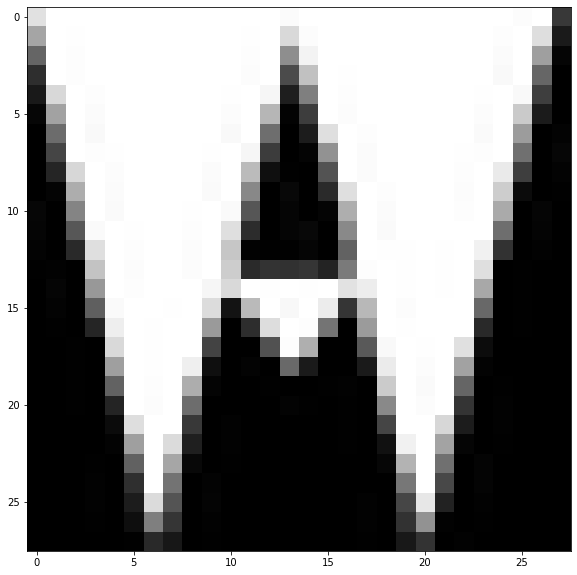

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(17,10))
letter = 'A'
img = cv2.imread(os.path.join(DATA_DIR, letter, os.listdir(f'{DATA_DIR}/{letter}/')[1]))
plt.imshow(img)

In [23]:
import os
import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import Conv2D, MaxPool2D, InputLayer, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPool2D
from keras.models import Model

pic_size = 28
n_classes = len(os.listdir(DATA_DIR))

def build_model(decomposition_rank, memory=True):
    model = keras.Sequential([
        ConvDecomposed2D(32, 3, decomposition_rank=decomposition_rank,
                        input_shape=(pic_size, pic_size, 3),
                         use_memory=memory, use_memory_test=memory,
                            data_format="channels_last", activation='relu',
                            padding='same'),
        keras.layers.MaxPooling2D(),
        ConvDecomposed2D(32, 3, decomposition_rank=decomposition_rank,
                         use_memory=memory, use_memory_test=memory,
                        activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        ConvDecomposed2D(16, 3, decomposition_rank=decomposition_rank,
                         use_memory=memory, use_memory_test=memory,
                        activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.summary()
    return model

In [20]:
from keras.preprocessing.image import ImageDataGenerator

# Подсказка: train/val split удобно делать вот так https://stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in (самый залайканый ответ)

""" Data generators initialization: for train and validation sets """
generator = ImageDataGenerator(validation_split=0.1, rescale=1./255)
train_gen = generator.flow_from_directory(DATA_DIR,
                                          target_size=(pic_size, pic_size),
                                          class_mode='categorical',
                                          subset='training', seed=1)
val_gen = generator.flow_from_directory(DATA_DIR,
                                        target_size=(pic_size, pic_size),
                                        class_mode='categorical',
                                        subset='validation', seed=1)

Found 476205 images belonging to 10 classes.
Found 52909 images belonging to 10 classes.


#### Модель с обычными свёрточными слоями

In [21]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, input_shape=(pic_size, pic_size, 3),
                        data_format="channels_last", activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0

In [22]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 146s 10ms/step - loss: 0.4472 - accuracy: 0.8672 - val_loss: 0.2577 - val_accuracy: 0.9230
Epoch 2/2
14881/14881 [==============================] - 143s 10ms/step - loss: 0.2818 - accuracy: 0.9140 - val_loss: 0.2328 - val_accuracy: 0.9308


#### decomposition_rank = 1 (with use_memory=False)

In [24]:
model1 = build_model(1, False) # the function was trivially changed for this

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_decomposed2d_5 (ConvDec (None, 28, 28, 32)        76        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv_decomposed2d_6 (ConvDec (None, 14, 14, 32)        105       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv_decomposed2d_7 (ConvDec (None, 7, 7, 16)          73        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)              

In [25]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model1.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 158s 11ms/step - loss: 0.8050 - accuracy: 0.7536 - val_loss: 0.5053 - val_accuracy: 0.8517
Epoch 2/2
14881/14881 [==============================] - 157s 11ms/step - loss: 0.5571 - accuracy: 0.8318 - val_loss: 0.4567 - val_accuracy: 0.8602


#### decomposition_rank = 1

In [27]:
model1 = build_model(1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_decomposed2d_8 (ConvDec (None, 28, 28, 32)        76        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv_decomposed2d_9 (ConvDec (None, 14, 14, 32)        105       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv_decomposed2d_10 (ConvDe (None, 7, 7, 16)          73        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 144)              

In [28]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model1.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 148s 10ms/step - loss: 0.8077 - accuracy: 0.7562 - val_loss: 0.4956 - val_accuracy: 0.8524
Epoch 2/2
14881/14881 [==============================] - 147s 10ms/step - loss: 0.5580 - accuracy: 0.8324 - val_loss: 0.4778 - val_accuracy: 0.8560


#### decomposition_rank = 17 (with use_memory=False)

In [32]:
model17 = build_model(17, False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_decomposed2d_14 (ConvDe (None, 28, 28, 32)        1044      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_decomposed2d_15 (ConvDe (None, 14, 14, 32)        3721      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv_decomposed2d_16 (ConvDe (None, 7, 7, 16)          3264      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 144)              

In [33]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model17.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 164s 11ms/step - loss: 0.4669 - accuracy: 0.8608 - val_loss: 0.2551 - val_accuracy: 0.9242
Epoch 2/2
14881/14881 [==============================] - 161s 11ms/step - loss: 0.2945 - accuracy: 0.9099 - val_loss: 0.2375 - val_accuracy: 0.9281


#### decomposition_rank = 17

In [ ]:
16 * 16 + 16 * 3 * 3 * 17 + 17 * 32 + 16 # bias

3264

In [29]:
model17 = build_model(17)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_decomposed2d_11 (ConvDe (None, 28, 28, 32)        1044      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv_decomposed2d_12 (ConvDe (None, 14, 14, 32)        3721      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv_decomposed2d_13 (ConvDe (None, 7, 7, 16)          3264      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)              

In [30]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model17.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 152s 10ms/step - loss: 0.4792 - accuracy: 0.8560 - val_loss: 0.2620 - val_accuracy: 0.9213
Epoch 2/2
14881/14881 [==============================] - 149s 10ms/step - loss: 0.2993 - accuracy: 0.9085 - val_loss: 0.2371 - val_accuracy: 0.9285
